In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()

        # Load pre-trained VGG16
        self.vgg = models.vgg16(pretrained=True)
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.vgg_features = nn.Sequential(*list(self.vgg.features.children()))
        self.vgg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Load pre-trained MobileNetV2
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        for param in self.mobilenet.parameters():
            param.requires_grad = False
        self.mobilenet_features = nn.Sequential(*list(self.mobilenet.features.children()))
        self.mobilenet_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Combined feature size: 512 (VGG16) + 1280 (MobileNetV2)
        combined_feature_size = 512 + 1280

        # Attention mechanism
        self.attention_dense = nn.Linear(combined_feature_size, combined_feature_size)

        # Classifier head
        self.fc1 = nn.Linear(combined_feature_size, 256)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(256, 1)

    def forward(self, x):
        # Extract VGG features
        vgg_out = self.vgg_features(x)
        vgg_out = self.vgg_pool(vgg_out)
        vgg_out = vgg_out.view(vgg_out.size(0), -1)

        # Extract MobileNet features
        mobilenet_out = self.mobilenet_features(x)
        mobilenet_out = self.mobilenet_pool(mobilenet_out)
        mobilenet_out = mobilenet_out.view(mobilenet_out.size(0), -1)

        # Combine features
        combined = torch.cat((vgg_out, mobilenet_out), dim=1)

        # Attention mechanism
        attention = torch.sigmoid(self.attention_dense(combined))
        attended = combined * attention

        # Classifier
        x = F.relu(self.fc1(attended))
        x = self.dropout(x)
        x = torch.sigmoid(self.output(x))
        return x

# Instantiate model
hybrid_model = HybridModel()

# Optimizer and loss function
optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# Model summary (optional with torchinfo)
try:
    from torchinfo import summary
    summary(hybrid_model, input_size=(1, 3, 224, 224))
    print(summary(hybrid_model, input_size=(1, 3, 224, 224)))
except ImportError:
    print("Install 'torchinfo' for model summary.")

Layer (type:depth-idx)                             Output Shape              Param #
HybridModel                                        [1, 1]                    124,923,856
├─Sequential: 1-1                                  [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                                 [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                                   [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                                 [1, 64, 224, 224]         (36,928)
│    └─ReLU: 2-4                                   [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                              [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                                 [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-7                                   [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                                 [1, 128, 112, 112]        (147,584)
│    └─ReLU: 2-9                                   [1, 128, 112, 112]        --
│ 

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import os

# Define transforms similar to Keras ImageDataGenerator
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),  # Approx zoom_range
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, shear=10, translate=(0.1, 0.1)),  # shear and shift
    transforms.ToTensor()
])

dataset_path = "C:\\Users\\samia\\Documents\\VS code\\CSE366_Research\\dataset_mini\\CT Scan\\ct_training_mini" # Update with your dataset path
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dataset: 80% train, 20% validation
val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader_ct = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader_ct = DataLoader(val_dataset, batch_size=32, shuffle=True)


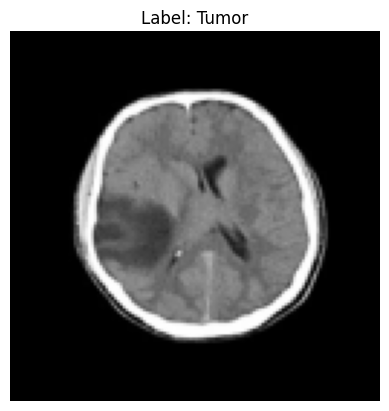

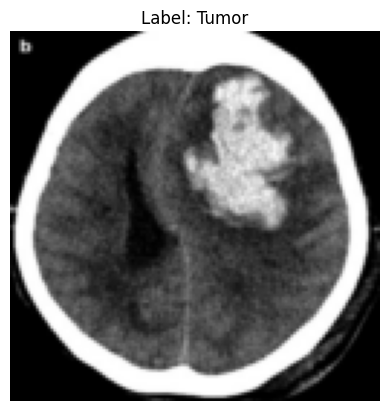

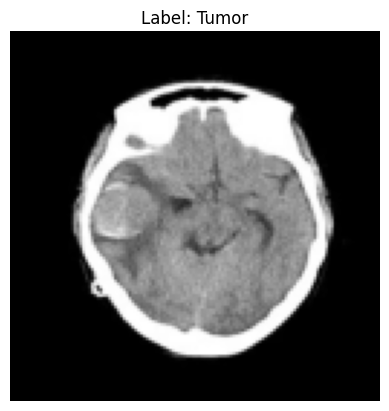

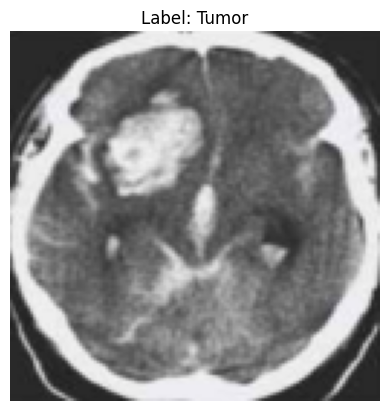

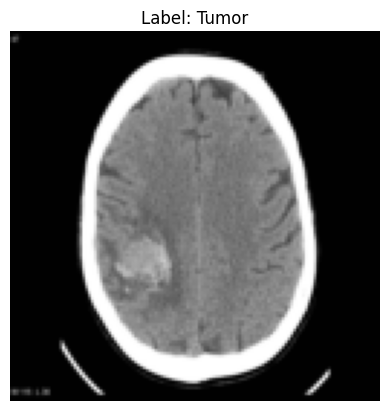

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

dataset_path = "C:\\Users\\samia\\Documents\\VS code\\CSE366_Research\\dataset_mini\\CT Scan\\ct_training_mini" # Update with your dataset path
# Image transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Lists to hold image tensors and labels
images = []
labels = []

# Load images and assign labels
for label_folder in ['Tumor', 'Healthy']:
    folder_path = os.path.join(dataset_path, label_folder)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img)
            images.append(img_tensor)
            labels.append(1 if label_folder == 'Tumor' else 0)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

# Convert lists to tensors or numpy arrays
images_np = torch.stack(images).numpy()  # shape: (N, C, H, W)
labels_np = np.array(labels)

# Visualize first 5 images
for i in range(5):
    img = np.transpose(images_np[i], (1, 2, 0))  # convert from (C, H, W) to (H, W, C)
    plt.imshow((img * 255).astype('uint8'))  # Rescale to [0, 255] and convert to uint8
    plt.title(f"Label: {'Tumor' if labels_np[i] == 1 else 'Healthy'}")
    plt.axis('off')
    plt.show()


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = hybrid_model.to(device)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tqdm import tqdm
import numpy as np

# Loss & optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Early stopping settings
patience = 3
best_val_loss = float('inf')
counter = 0

# History dictionary
history = {
    'loss': [], 'val_loss': [],
    'precision': [], 'val_precision': [],
    'recall': [], 'val_recall': [],
    'accuracy': [], 'val_accuracy': []
}

num_epochs = 10
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    train_losses, y_true_train, y_pred_train = [], [], []
    train_loop = tqdm(train_loader_ct, desc='Training', leave=False)
    for inputs, targets in train_loop:
        inputs, targets = inputs.to(device), targets.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        preds = (outputs > 0.5).int()
        y_true_train.extend(targets.cpu().numpy())
        y_pred_train.extend(preds.cpu().numpy())

    train_loss = np.mean(train_losses)
    train_precision = precision_score(y_true_train, y_pred_train)
    train_recall = recall_score(y_true_train, y_pred_train)
    train_accuracy = accuracy_score(y_true_train, y_pred_train)

    # Validation phase
    model.eval()
    val_losses, y_true_val, y_pred_val = [], [], []
    val_loop = tqdm(validation_loader_ct, desc='Validating', leave=False)
    with torch.no_grad():
        for inputs, targets in val_loop:
            inputs, targets = inputs.to(device), targets.to(device).float().view(-1, 1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_losses.append(loss.item())
            preds = (outputs > 0.5).int()
            y_true_val.extend(targets.cpu().numpy())
            y_pred_val.extend(preds.cpu().numpy())

    val_loss = np.mean(val_losses)
    val_precision = precision_score(y_true_val, y_pred_val)
    val_recall = recall_score(y_true_val, y_pred_val)
    val_accuracy = accuracy_score(y_true_val, y_pred_val)

    # Save metrics
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['precision'].append(train_precision)
    history['val_precision'].append(val_precision)
    history['recall'].append(train_recall)
    history['val_recall'].append(val_recall)
    history['accuracy'].append(train_accuracy)
    history['val_accuracy'].append(val_accuracy)

    # Print summary for epoch
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break



Epoch 1/10


C:\Users\samia\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 0.6797 | Val Loss: 0.6912 | Acc: 0.6875 | Val Acc: 0.5000

Epoch 2/10


C:\Users\samia\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 0.6826 | Val Loss: 0.6918 | Acc: 0.6250 | Val Acc: 0.5000

Epoch 3/10


C:\Users\samia\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 0.6772 | Val Loss: 0.6959 | Acc: 0.6875 | Val Acc: 0.5000

Epoch 4/10


C:\Users\samia\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 0.6611 | Val Loss: 0.6974 | Acc: 0.7812 | Val Acc: 0.5000
Early stopping triggered!


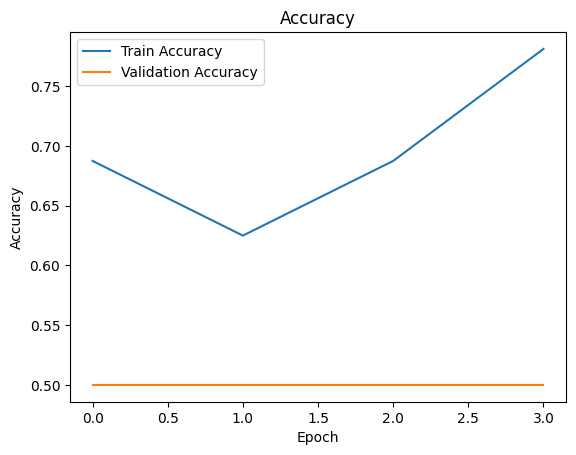

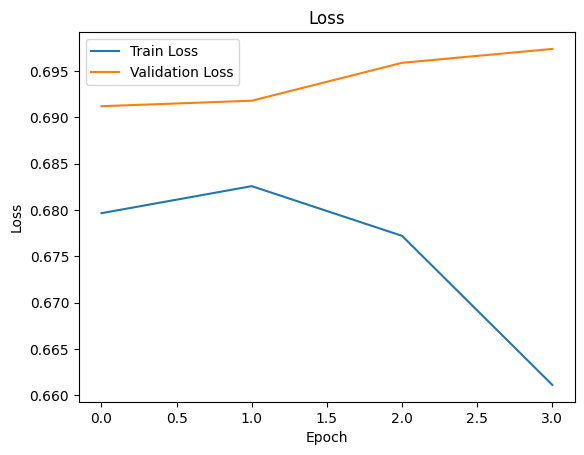

In [7]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Loss plot
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


#**Testing**#

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Same as training
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  # Standard ImageNet norm
])

test_dir = "C:\\Users\\samia\\Documents\\VS code\\CSE366_Research\\dataset_mini\\CT Scan\\ct_testing_mini"
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        preds = (outputs > 0.5).int().view(-1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Evaluation metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

     healthy       0.38      0.69      0.50        36
       tumor       0.31      0.11      0.16        45

    accuracy                           0.37        81
   macro avg       0.35      0.40      0.33        81
weighted avg       0.34      0.37      0.31        81

Confusion Matrix:
[[25 11]
 [40  5]]


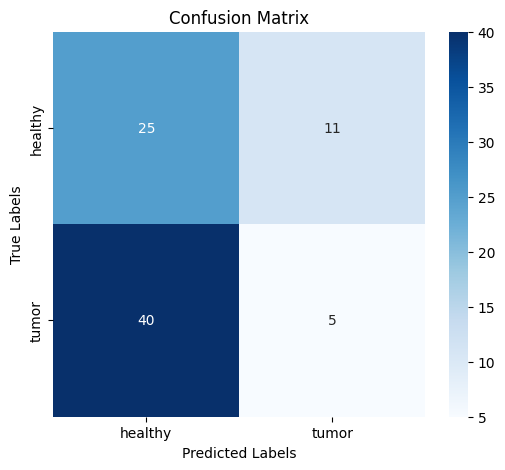

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Define class names in the same order as ImageFolder assigns (alphabetical)
class_names = test_dataset.classes  # ['healthy', 'tumor']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
